# Plot creation

In [1]:
import glob

In [2]:
res = glob.glob('/cassini_ringsdata/opus/N*/*.map.dst.cal.cub')

In [3]:
fnames = pd.Series(res)
fnames.head()

0    /cassini_ringsdata/opus/N1585782249/N158578224...
1    /cassini_ringsdata/opus/N1591063671/N159106367...
2    /cassini_ringsdata/opus/N1654259210/N165425921...
3    /cassini_ringsdata/opus/N1541717040/N154171704...
4    /cassini_ringsdata/opus/N1541714976/N154171497...
dtype: object

In [4]:
fnames.size

481

In [5]:
SOI = fnames[fnames.str.contains('N146734')]

In [6]:
SOI

27     /cassini_ringsdata/opus/N1467347445/N146734744...
44     /cassini_ringsdata/opus/N1467347249/N146734724...
46     /cassini_ringsdata/opus/N1467345857/N146734585...
115    /cassini_ringsdata/opus/N1467345621/N146734562...
129    /cassini_ringsdata/opus/N1467345680/N146734568...
134    /cassini_ringsdata/opus/N1467345916/N146734591...
146    /cassini_ringsdata/opus/N1467346329/N146734632...
155    /cassini_ringsdata/opus/N1467345503/N146734550...
163    /cassini_ringsdata/opus/N1467346388/N146734638...
164    /cassini_ringsdata/opus/N1467347504/N146734750...
178    /cassini_ringsdata/opus/N1467346211/N146734621...
227    /cassini_ringsdata/opus/N1467345975/N146734597...
231    /cassini_ringsdata/opus/N1467346034/N146734603...
239    /cassini_ringsdata/opus/N1467345562/N146734556...
289    /cassini_ringsdata/opus/N1467346565/N146734656...
295    /cassini_ringsdata/opus/N1467345444/N146734544...
309    /cassini_ringsdata/opus/N1467346152/N146734615...
329    /cassini_ringsdata/opus/

In [34]:
def convert_to_png(fname):
    import gdal
    from pyciss import io
    ds = gdal.Open(fname)
    if ds.RasterXSize > 5200:
        return fname, False
    cube = io.RingCube.open(fname)
    cube.imshow(save=True)
    return fname, True

In [35]:
from IPython.parallel import Client
c = Client()

In [36]:
lbview = c.load_balanced_view()

In [37]:
results = lbview.map_async(convert_to_png, SOI)

In [38]:
from iuvs.multitools import *

In [39]:
from time import sleep
prog = IntProgress(min=0, max=len(SOI))
display(prog)
while not results.ready():
    sleep(5)
    prog.value = results.progress
print("Done.")

Done.


In [41]:
results.result

[('/cassini_ringsdata/opus/N1467347445/N1467347445_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467347249/N1467347249_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467345857/N1467345857_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467345916/N1467345916_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346329/N1467346329_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346388/N1467346388_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467347504/N1467347504_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467345975/N1467345975_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346034/N1467346034_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346565/N1467346565_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467345444/N1467345444_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346152/N1467346152_2.map.dst.cal.cub', True),
 ('/cassini_ringsdata/opus/N1467346624/N1467346624_2.map.dst.cal

In [45]:
for fname in SOI:
    !cp {fname.split('.')[0]+'.png'} /cassini_ringsdata/SOI

# Comparison

In [9]:
plt.ioff()
import os
for fname in SOI:
    print(os.path.basename(fname))
    fig, axes = plt.subplots(ncols=2, figsize=io.calc_4_3(10))
    oldcube = io.RingCube.open(fname.split('.')[0]+'.map.cal.cub')
    oldcube.imshow(ax=axes[0])
    newcube = io.RingCube.open(fname)
    newcube.imshow(ax=axes[1])
    savename = os.path.basename(fname).split('.')[0]+'_compare.png'
    fig.savefig('/cassini_ringsdata/SOI/'+savename, dpi=150)

N1467347445_2.map.dst.cal.cub
N1467347249_2.map.dst.cal.cub
N1467345857_2.map.dst.cal.cub
N1467345621_2.map.dst.cal.cub
N1467345680_2.map.dst.cal.cub
N1467345916_2.map.dst.cal.cub
N1467346329_2.map.dst.cal.cub
N1467345503_2.map.dst.cal.cub
N1467346388_2.map.dst.cal.cub
N1467347504_2.map.dst.cal.cub
N1467346211_2.map.dst.cal.cub
N1467345975_2.map.dst.cal.cub
N1467346034_2.map.dst.cal.cub
N1467345562_3.map.dst.cal.cub
N1467346565_2.map.dst.cal.cub
N1467345444_2.map.dst.cal.cub
N1467346152_2.map.dst.cal.cub
N1467346624_2.map.dst.cal.cub
N1467346506_2.map.dst.cal.cub
N1467346270_2.map.dst.cal.cub
N1467347210_2.map.dst.cal.cub
N1467345798_2.map.dst.cal.cub
N1467345739_2.map.dst.cal.cub
N1467346093_2.map.dst.cal.cub
N1467346447_2.map.dst.cal.cub


/usr/local/python/miniconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [10]:
cd /cassini_ringsdata/opus/N1467346447/

/cassini_ringsdata/opus/N1467346447


In [11]:
ll

total 31556
-rwx------. 1 1453592717  4291580 Jun  5 15:15 N1467346447_2.cal.cub*
-rwx------. 1 1453592717  2195416 Jun  5 15:14 N1467346447_2.cub*
-rwx------. 1 1453592717  4292330 Jun  5 15:15 N1467346447_2.dst.cal.cub*
-rwx------. 1 1453592717  2127944 Jun  3 15:19 N1467346447_2.IMG*
-rwx------. 1 1453592717     3628 Jun  3 15:19 N1467346447_2.LBL*
-rwx------. 1 1453592717 20475908 Jun  3 15:19 N1467346447_2.map.cal.cub*
-rwx------. 1 1453592717      124 Jun  3 15:19 N1467346447_2.map.cal.pgw*
-rwx------. 1 1453592717 20476493 Jun  5 15:15 N1467346447_2.map.dst.cal.cub*
-rwx------. 1 1453592717   486597 Jun  5 15:16 N1467346447_2.png*


In [12]:
cube= io.RingCube.open('./N1467346447_2.map.dst.cal.cub')

In [20]:
plt.ion()
%matplotlib nbagg

<IPython.core.display.Javascript object>


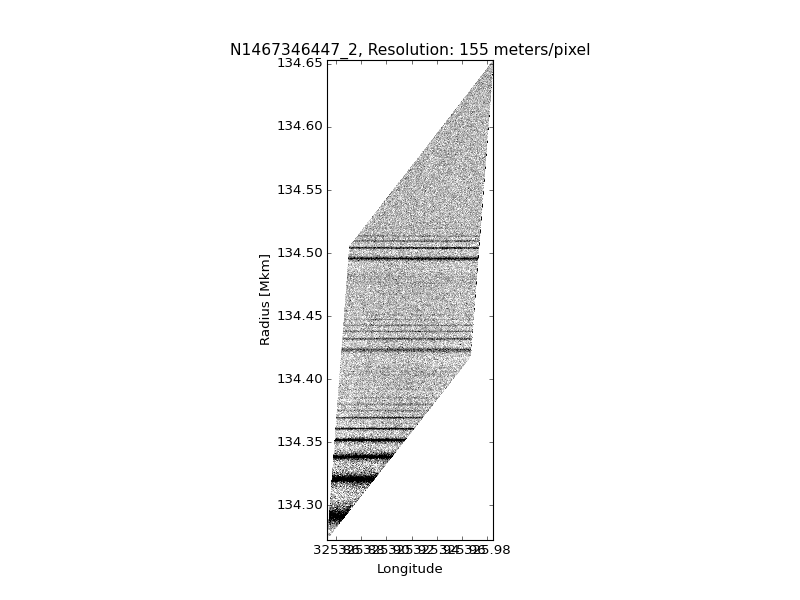

In [21]:
cube.imshow()

In [14]:
plt.close('all')